## Converting `FastAi` Notebook to Train in Distributed-Data-Parallel

This notebook is taken straight from [Lesson3-CamVid](), and requires only 3 new cells to make it run in DDP.

* Step 1: [Initialization of `Ddip` extension and creation of a DDP group](#ddipp_step_1)
* Step 2: [Load libraries common to both local and remote processes](#ddipp_step_2)
* Step 3: [Get ready to create training dataset, and turn on automatic DDP mode](#ddipp_step_3)
* Enjoy the training, but [watch out any uncoordinated I/O/file/disk operations when in DDP mode.](#ddipp_datacorruption)
* [Things to watch out](#ddipp_datacorruption), and [exiting the DDP group](#ddipp_exit)

## Image segmentation with CamVid

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

**ddipp usage - Step 1 - Initialization**<a name="ddipp_step_1"></a>

To use DDP with fastai notebook, the first line loads the extension.

The second line creates an ipyparallel cluster and a DDP process group, and prepare fastai notebook to use Distributed Data Parallel interactively later.

In [2]:
%load_ext ippddp.Ddip
# %makedip -g all -a fastai_v1 --verbose True

**ddipp usage Step 2 - Importing libraries commonly used**<a name="ddipp_step_2"></a>

The `%%dip everywhere` says "Execute this cell in both the local notebook and in the DDP process group."
These `fastai` libraries are used in both data loading/preparation, and in model training.
`%%dip everywhere` makes them available on both local and remote processes.

Note: Any '%%' cell magic must be the first line of the cell, and its effect is limited to
this cell phone.

In [3]:
from ippddp.Ddip.ddp import IppCluster as ipc

In [7]:
# ipc.kill_cluster()
%makedip -k

Proc [7415] DDP.exit_group(): [0, 1, 2]
Proc [7415] Terminating ipcluster process [7445] with by 'ipcluster stop', just a few seconds ....
Proc [7415] no running ipcluster process.


In [8]:
%makedip -g all -a fastai_v1 --verbose False

Waiting for connection file: ~/.ipython/profile_default/security/ipcontroller-ippdpp_c-client.json


In [9]:
%%dip everywhere
from fastai.vision import *
from fastai.callbacks.hooks import *
from fastai.utils.mem import *

**ddipp usage**

The next few cells load the data from disk to memory, then inspect and manipulate them.
Almost all these tasks don't involve GPU, and can be done in the local notebook.
After that, when we're ready to create the training data, we will use magics again.


In [10]:
path = untar_data(URLs.CAMVID)
path.ls()

[PosixPath('/home/ndim1/.fastai/data/camvid/valid.txt'),
 PosixPath('/home/ndim1/.fastai/data/camvid/images'),
 PosixPath('/home/ndim1/.fastai/data/camvid/codes.txt'),
 PosixPath('/home/ndim1/.fastai/data/camvid/labels')]

In [11]:
path_lbl = path/'labels'
path_img = path/'images'

## Subset classes

In [12]:
# path = Path('./data/camvid-small')

# def get_y_fn(x): return Path(str(x.parent)+'annot')/x.name

# codes = array(['Sky', 'Building', 'Pole', 'Road', 'Sidewalk', 'Tree',
#     'Sign', 'Fence', 'Car', 'Pedestrian', 'Cyclist', 'Void'])

# src = (SegmentationItemList.from_folder(path)
#        .split_by_folder(valid='val')
#        .label_from_func(get_y_fn, classes=codes))

# bs=8
# data = (src.transform(get_transforms(), tfm_y=True)
#         .databunch(bs=bs)
#         .normalize(imagenet_stats))

## Data

In [13]:
fnames = get_image_files(path_img)
fnames[:3]

[PosixPath('/home/ndim1/.fastai/data/camvid/images/0001TP_006750.png'),
 PosixPath('/home/ndim1/.fastai/data/camvid/images/0001TP_007620.png'),
 PosixPath('/home/ndim1/.fastai/data/camvid/images/Seq05VD_f01590.png')]

In [14]:
lbl_names = get_image_files(path_lbl)
lbl_names[:3]

[PosixPath('/home/ndim1/.fastai/data/camvid/labels/0016E5_06540_P.png'),
 PosixPath('/home/ndim1/.fastai/data/camvid/labels/0006R0_f01050_P.png'),
 PosixPath('/home/ndim1/.fastai/data/camvid/labels/0016E5_04830_P.png')]

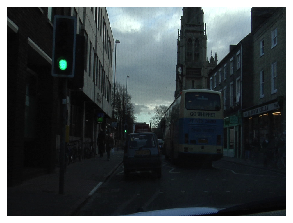

In [15]:
img_f = fnames[0]
img = open_image(img_f)
img.show(figsize=(5,5))

In [16]:
get_y_fn = lambda x: path_lbl/f'{x.stem}_P{x.suffix}'

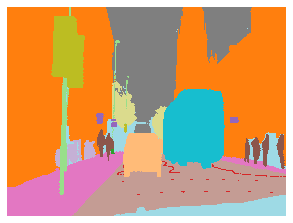

In [17]:
mask = open_mask(get_y_fn(img_f))
mask.show(figsize=(5,5), alpha=1)

In [18]:
src_size = np.array(mask.shape[1:])
src_size,mask.data

(array([720, 960]), tensor([[[ 4,  4,  4,  ...,  4,  4,  4],
          [ 4,  4,  4,  ...,  4,  4,  4],
          [ 4,  4,  4,  ...,  4,  4,  4],
          ...,
          [19, 19, 19,  ..., 30, 30, 30],
          [19, 19, 19,  ..., 30, 30, 30],
          [19, 19, 19,  ..., 30, 30, 30]]]))

In [19]:
codes = np.loadtxt(path/'codes.txt', dtype=str); codes

array(['Animal', 'Archway', 'Bicyclist', 'Bridge', 'Building', 'Car', 'CartLuggagePram', 'Child', 'Column_Pole',
       'Fence', 'LaneMkgsDriv', 'LaneMkgsNonDriv', 'Misc_Text', 'MotorcycleScooter', 'OtherMoving', 'ParkingBlock',
       'Pedestrian', 'Road', 'RoadShoulder', 'Sidewalk', 'SignSymbol', 'Sky', 'SUVPickupTruck', 'TrafficCone',
       'TrafficLight', 'Train', 'Tree', 'Truck_Bus', 'Tunnel', 'VegetationMisc', 'Void', 'Wall'], dtype='<U17')

## Datasets

In [20]:
size = src_size//2

free = gpu_mem_get_free_no_cache()
# the max size of bs depends on the available GPU RAM
if free > 8200: bs=8
else:           bs=4
print(f"using bs={bs}, have {free}MB of GPU RAM free")

using bs=8, have 11163MB of GPU RAM free


In [21]:
src = (SegmentationItemList.from_folder(path_img)
       .split_by_fname_file('../valid.txt')
       .label_from_func(get_y_fn, classes=codes))

**ddipp usage Step 3: Gather up and push parameters to create training dataset, and turn on the automatic DDP mode!**<a name="ddipp_step_3"></a>

Training dataset is best created on the DDP side.  Thus any parameters, objects, augmentation
functions needed to create the training dataset, should be available to the factory method as well.
`%dipush` is for this job.

Subsequent cells can mostly run in DDP mode --- thus instead of manually and repeatedly
prepend each cell with `%%dip`, we can turn on automatic DDP mode with `%autodip on`.

In [22]:
%dipush src bs size get_transforms src_size path path_lbl path_img codes get_y_fn
%autodip on

Auto Execution on DDP group: on, will run cell as %%dip


In [23]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

**ddipp usage**

Voila!  The cell above was executed in the DDP group bound to the list of GPUs!

All cells following from here will be run in DDP mode, unless:

  1. we flip the %autodip switch to off, OR

  2. we begin a cell with '%%dip local' or '#dip_locally'

[output:0]

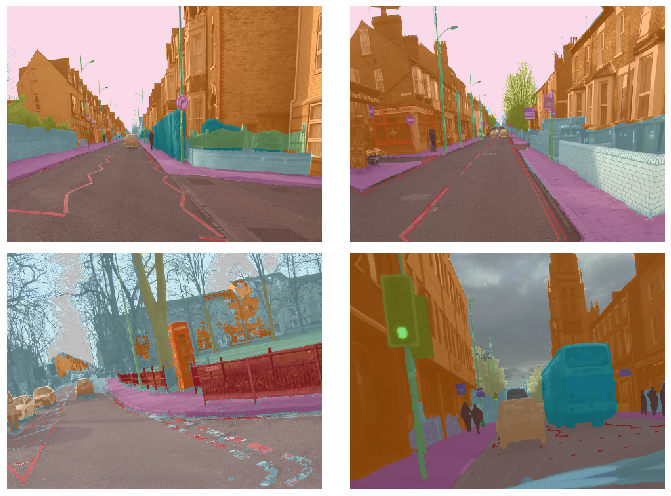

In [24]:
data.show_batch(2, figsize=(10,7))

[output:0]

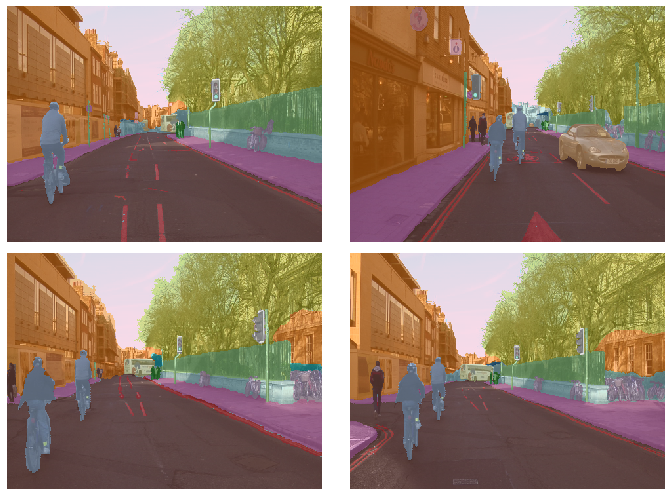

In [25]:
data.show_batch(2, figsize=(10,7), ds_type=DatasetType.Valid)

## Model

In [26]:
name2id = {v:k for k,v in enumerate(codes)}
void_code = name2id['Void']

def acc_camvid(input, target):
    target = target.squeeze(1)
    mask = target != void_code
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

In [27]:
metrics=acc_camvid
# metrics=accuracy

In [28]:
wd=1e-2

In [29]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd)

epoch     train_loss  valid_loss  acc_camvid  time    
0         1372.404907 #na#        00:44       ███----| 90.67% [68/75 00:44<00:04 5.7423]
LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


[output:0]

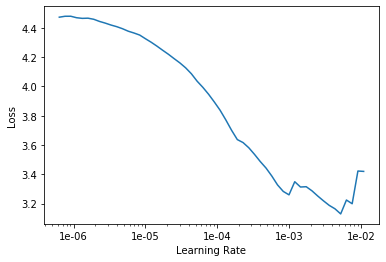

In [30]:
# lr_find(learn)
learn.lr_find()
learn.recorder.plot()

In [31]:
lr=3e-3

In [32]:
learn.fit_one_cycle(2, slice(lr), pct_start=0.9)

epoch     train_loss  valid_loss  acc_camvid  time    
0         1.879783    1.637566    0.585059    00:30                                      
1         1.659730    1.062622    0.735852    00:20                                      


In [26]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.9)

%%dip : Running cell in remote DDP namespace (GPUs: [0, 1, 2]).
epoch     train_loss  valid_loss  acc_camvid  time    
0         1.929998    1.219868    0.698676    00:29                                       
1         1.377625    0.778797    0.819635    00:20                                       
2         1.082473    0.628670    0.841039    00:20                                       
3         0.895123    0.542082    0.848581    00:20                                       
4         0.798098    1.058631    0.680381    00:20                                       
5         1.226101    1.717626    0.501437    00:20                                       
6         1.323576    1.622092    0.558490    00:20                                       
7         1.346415    1.356290    0.641308    00:20                                       
8         1.298726    1.434632    0.606883    00:20                                       
9         1.203344    1.055968    0.711957    00:20           


**ddipp things to watch-out**<a name='ddipp_datacorruption'></a>

Learner.load() and .save() DDP-safe, but watch out for any other concurrent file or disk operations though.
They need to be either coordinated with explicit synchronization, or designated to be run in only one process.


In [ ]:
learn.save('stage-1')

In [27]:
learn.load('stage-1');

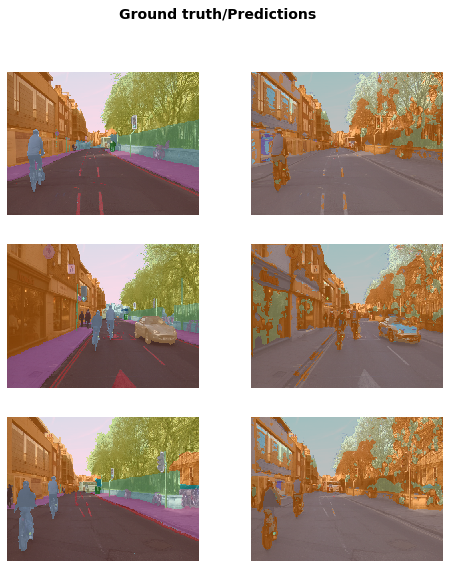

In [28]:
learn.show_results(rows=3, figsize=(8,9))

In [29]:
learn.unfreeze()

In [30]:
lrs = slice(lr/400,lr/4)

In [33]:
import gc
gc.collect()
torch.cuda.empty_cache()
learn.fit_one_cycle(12, lrs, pct_start=0.8)

epoch,train_loss,valid_loss,acc_camvid,time
0,1.157583,1.246414,0.630886,00:46
1,1.069812,1.043191,0.716441,00:46
2,0.940804,0.789624,0.772274,00:46


KeyboardInterrupt: 

In [ ]:
learn.save('stage-2');

## Go big

You may have to restart your kernel and come back to this stage if you run out of memory, and may also need to decrease `bs`.

In [34]:
learn.destroy()

size = src_size

free = gpu_mem_get_free_no_cache()
# the max size of bs depends on the available GPU RAM
if free > 8200: bs=2
else:           bs=1
print(f"using bs={bs}, have {free}MB of GPU RAM free")

this Learner object self-destroyed - it still exists, but no longer usable
using bs=1, have 3596MB of GPU RAM free


In [35]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

In [36]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd)

In [37]:
learn.load('stage-2');

epoch,train_loss,valid_loss,acc_camvid,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


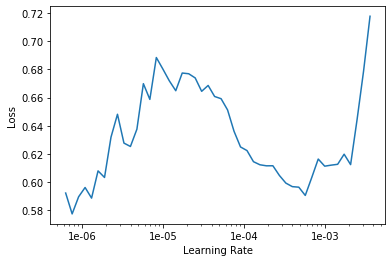

In [38]:
# lr_find(learn)
learn.lr_find()
learn.recorder.plot()

In [39]:
lr=1e-3

In [40]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.8)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.477692,0.391066,0.895343,03:11
1,0.477334,0.428170,0.884474,03:11


KeyboardInterrupt: 

In [ ]:
learn.save('stage-1-big')

In [41]:
learn.load('stage-1-big');

In [42]:
learn.unfreeze()

In [44]:
lrs = slice(1e-6,lr/10)

In [ ]:
learn.fit_one_cycle(10, lrs)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.291915,0.280977,0.922024,03:22
1,0.287652,0.288885,0.919372,03:22


In [ ]:
learn.save('stage-2-big')

In [ ]:
learn.load('stage-2-big');

In [ ]:
learn.show_results(rows=3, figsize=(10,10))

## fin

**ddipp usage : shutting down the DDP servers**<a name="ddipp_exit"></a>

`%makedip --kill` to terminate the DDP group and the cluster, keeping the notebook session alive.
To kill everything and start from scratch, use the Kernel --> Restart menu choice.
